In [ ]:
!pip install pycuda


/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


[DIP+SR+GAN] Iter 0/1500 | DIP=0.37199 | ADV=0.69917 | D=0.68135
[DIP+SR+GAN] Iter 100/1500 | DIP=0.02803 | ADV=0.70434 | D=0.68780
[DIP+SR+GAN] Iter 200/1500 | DIP=0.01387 | ADV=0.72507 | D=0.66436
[DIP+SR+GAN] Iter 300/1500 | DIP=0.00887 | ADV=0.78417 | D=0.62248
[DIP+SR+GAN] Iter 400/1500 | DIP=0.00703 | ADV=0.81576 | D=0.62462
[DIP+SR+GAN] Iter 500/1500 | DIP=0.00388 | ADV=0.70698 | D=0.69682
[DIP+SR+GAN] Iter 600/1500 | DIP=0.00235 | ADV=0.68751 | D=0.70276
[DIP+SR+GAN] Iter 700/1500 | DIP=0.00161 | ADV=0.69335 | D=0.69691
[DIP+SR+GAN] Iter 800/1500 | DIP=0.00111 | ADV=0.69390 | D=0.69529
[DIP+SR+GAN] Iter 900/1500 | DIP=0.00078 | ADV=0.69132 | D=0.69449
[DIP+SR+GAN] Iter 1000/1500 | DIP=0.00069 | ADV=0.69306 | D=0.69395
[DIP+SR+GAN] Iter 1100/1500 | DIP=0.00067 | ADV=0.68682 | D=0.69443
[DIP+SR+GAN] Iter 1200/1500 | DIP=0.00038 | ADV=0.68927 | D=0.69387
[DIP+SR+GAN] Iter 1300/1500 | DIP=0.00023 | ADV=0.68991 | D=0.69439
[DIP+SR+GAN] Iter 1400/1500 | DIP=0.00056 | ADV=0.68416 | D=

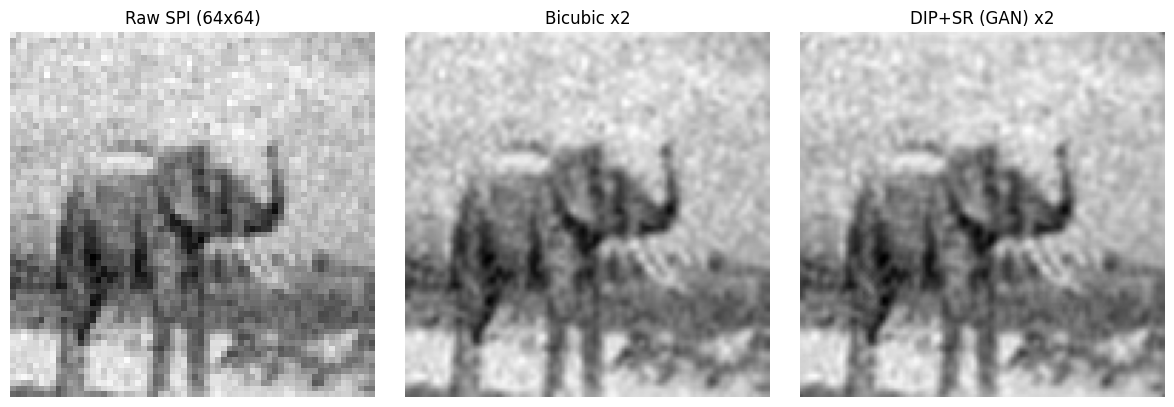


==== Performance & Memory Stats ====
Total Execution Time: 14.97 sec
Peak GPU Memory Allocated: 336.51 MB
Peak GPU Memory Reserved:  370.00 MB
Done.


In [ ]:
import numpy as np
import math
import cv2
import scipy.io
import matplotlib.pyplot as plt
import time

# ======== PyTorch ========
import torch
import torch.nn as nn
import torch.optim as optim
torch.backends.cudnn.benchmark = True  # Accelerate conv by choosing best algorithms

# ======== PyCUDA for GPU-based Hadamard SPI ========
import pycuda.autoinit
from pycuda import driver, gpuarray
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

############################################################
# Part 1: GPU-based SPI Reconstruction (Hadamard transform)
############################################################

#define warpSize 32
mod = SourceModule(r"""
__global__ void digitrevorder_kernel(int *x, int *vec, int *result, int N, int L, int base) {
    __shared__ int s_vec[32];
    int idx = threadIdx.x + blockDim.x * blockIdx.x;

    for (int i = threadIdx.x; i < L; i += blockDim.x) {
        s_vec[i] = vec[i];
    }
    __syncthreads();

    if (idx < ((N + warpSize - 1) / warpSize) * warpSize) {
        int res = 0;
        if (idx < N) {
            int temp = x[idx];
            #pragma unroll
            for (int k = L - 1; k >= 0; --k) {
                int div = temp / s_vec[k];
                res += div * s_vec[L - 1 - k];
                temp -= div * s_vec[k];
            }
            result[idx] = res;
        } else {
            result[idx] = 0;
        }
    }
}
""")

digitrevorder_kernel_2 = mod.get_function("digitrevorder_kernel")

def digitrevorder_cuda(x, base):
    """
    Reverses digit order in base 'base'. For bit-reversal, set base=2.
    """
    x = np.asarray(x, dtype=np.int32)
    N = len(x)
    rem = N
    L = 0
    while rem >= base:
        rem //= base
        L += 1
    if rem != 1:
        raise ValueError("Length of data must be a power of 'base'.")

    vec = np.array([base ** n for n in range(L)], dtype=np.int32)
    result = np.zeros_like(x)

    block_size = 256
    grid_size = (N + block_size - 1)//block_size

    digitrevorder_kernel_2(
        cuda.In(x),
        cuda.In(vec),
        cuda.Out(result),
        np.int32(N),
        np.int32(L),
        np.int32(base),
        block=(block_size,1,1),
        grid=(grid_size,1)
    )
    return result

def bitrevorder_cuda(x):
    idx = np.arange(len(x))
    idx_br = digitrevorder_cuda(idx, 2)
    return x[idx_br]

mod_fht = SourceModule(r"""
__global__ void fhtseq_inv_gpu(float *x, int N, int L)
{
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int threadNum = blockDim.x * gridDim.x;

    __shared__ float sdata[32];

    for(int pos = tid; pos < N; pos += threadNum) {
        sdata[threadIdx.x] = x[pos];
        __syncthreads();

        int k1 = N;
        int k2 = 1;
        int k3 = N >> 1;

        for(int i1 = 0; i1 < L; ++i1) {
            int L1 = 0;
            for(int i2 = 0; i2 < k2; ++i2) {
                bool isOdd = i2 & 1;
                for(int i3 = 0; i3 < k3; ++i3) {
                    int ii = i3 + L1;
                    int jj = ii + k3;

                    float temp1 = sdata[ii];
                    float temp2 = sdata[jj];

                    float add = temp1 + temp2;
                    float sub = temp1 - temp2;

                    sdata[ii] = isOdd ? sub : add;
                    sdata[jj] = isOdd ? add : sub;
                }
                L1 += k1;
            }
            k1 >>= 1;
            k2 <<= 1;
            k3 >>= 1;
        }
        x[pos] = sdata[threadIdx.x] / N;
        __syncthreads();
    }
}
""")

fhtseq_inv_gpu = mod_fht.get_function("fhtseq_inv_gpu")

def fhtseq_inv_2(data):
    data = data.astype(np.float32)
    N = len(data)
    L = int(np.log2(N))
    if (L - np.floor(L)) > 0:
        raise ValueError("Input length must be a power of 2.")

    data_br = bitrevorder_cuda(data)
    x_gpu = gpuarray.to_gpu(data_br)
    block_dim = (256,1,1)
    grid_dim = ((N+block_dim[0]-1)//block_dim[0],1)

    fhtseq_inv_gpu(
        x_gpu,
        np.int32(N),
        np.int32(L),
        block=block_dim,
        grid=grid_dim
    )
    return x_gpu.get()

def fwht2d_GPU(xx):
    """
    2D iFHT row->col on GPU. Minimal loops, concurrency possible.
    """
    N = xx.shape[0]
    temp = np.zeros_like(xx, dtype=np.float32)
    out  = np.zeros_like(xx, dtype=np.float32)

    # Rows
    for i in range(N):
        temp[i,:] = fhtseq_inv_2(xx[i,:])

    # Cols
    for j in range(N):
        out[:,j] = fhtseq_inv_2(temp[:,j])

    return out

def getHSPIReconstruction_GPU_P(dataMat, nStep=2):
    """
    GPU-based SPI with nStep=2 => difference => iFHT => reconstruction.
    """
    if nStep != 2:
        raise ValueError("Only nStep=2 is implemented.")
    spec = dataMat[:,:,0] - dataMat[:,:,1]
    img = fwht2d_GPU(spec)
    return img, spec

############################################################
# Part 2: DIP + SR + (Optional) Adversarial
############################################################

class DIP_SR_Generator(nn.Module):
    """
    DIP + SR in one pass using PixelShuffle(2).
    """
    def __init__(self, input_channels=1, hidden_channels=64, output_channels=1):
        super(DIP_SR_Generator, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*4, 3, 1, 1)
        self.pixelshuffle = nn.PixelShuffle(2)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, 3, 1, 1)
        self.conv4 = nn.Conv2d(hidden_channels, output_channels, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.pixelshuffle(out)
        out = self.relu(self.conv3(out))
        out = self.conv4(out)
        return out

class SimpleDiscriminator(nn.Module):
    """
    Minimal patch-based discriminator.
    """
    def __init__(self, in_channels=1, base_channels=64):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels*2, 1, 4, 1, 0)
        )
    def forward(self, x):
        return self.model(x)


################################################################################
#UNet
################################################################################
class UNetSR(nn.Module):
    """
    A U-Net architecture with super-resolution using PixelShuffle.
    Solves spatial dimension mismatches with interpolation.
    """

    def __init__(self, in_channels=1, out_channels=1, base_features=64):
        super(UNetSR, self).__init__()

        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features, base_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_features, base_features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 2, base_features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(base_features * 2, base_features * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 4, base_features * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_features * 4, base_features * 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 8, base_features * 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder with PixelShuffle
        self.upconv3 = nn.Conv2d(base_features * 8, base_features * 4 * 4, kernel_size=3, padding=1)
        self.pixel_shuffle3 = nn.PixelShuffle(2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(base_features * 4 + base_features * 4, base_features * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 4, base_features * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.Conv2d(base_features * 4, base_features * 2 * 4, kernel_size=3, padding=1)
        self.pixel_shuffle2 = nn.PixelShuffle(2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_features * 2 + base_features * 2, base_features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 2, base_features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.Conv2d(base_features * 2, base_features * 4, kernel_size=3, padding=1)
        self.pixel_shuffle1 = nn.PixelShuffle(2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_features + base_features, base_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features, base_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Final output layer
        self.final_conv = nn.Conv2d(base_features, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder with PixelShuffle
        # Upsample 1
        u3 = self.pixel_shuffle3(self.upconv3(b))
        if u3.shape[2:] != e3.shape[2:]:
            u3 = F.interpolate(u3, size=e3.shape[2:], mode='bilinear', align_corners=False)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))

        # Upsample 2
        u2 = self.pixel_shuffle2(self.upconv2(d3))
        if u2.shape[2:] != e2.shape[2:]:
            u2 = F.interpolate(u2, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        # Upsample 3
        u1 = self.pixel_shuffle1(self.upconv1(d2))
        if u1.shape[2:] != e1.shape[2:]:
            u1 = F.interpolate(u1, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        # Final output
        out = self.final_conv(d1)
        return out



def dip_gan_with_sr_measure(
    intensity_mat,
    nStep=2,
    upscale_factor=2,
    dip_iterations=300,
    lr=1e-3,
    use_discriminator=False,
    adv_weight=0.01,
    device='cuda'
):
    """
    DIP + SR + optional adversarial, with memory & timing measurements.
    Returns (final_upscaled, bicubic_target, raw_spi, stats_dict)
    where stats_dict has keys: 'exec_time_s', 'peak_mem_alloc_mb', 'peak_mem_reserved_mb'
    """
    # Start timing
    t0 = time.time()

    # Reset peak memory stats
    if device.startswith('cuda'):
        torch.cuda.reset_peak_memory_stats(device=device)

    # Reconstruct SPI
    raw_spi, _ = getHSPIReconstruction_GPU_P(intensity_mat, nStep=nStep)
    H, W = raw_spi.shape
    spi_min, spi_max = raw_spi.min(), raw_spi.max()

    if spi_max - spi_min > 1e-8:
        raw_norm = (raw_spi - spi_min)/(spi_max - spi_min)
    else:
        raw_norm = np.zeros_like(raw_spi, dtype=np.float32)

    upH, upW = H*upscale_factor, W*upscale_factor
    raw_torch = torch.tensor(raw_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    bicubic_target = nn.functional.interpolate(
        raw_torch,
        size=(upH, upW),
        mode='bicubic',
        align_corners=False
    )

    # DIP+SR generator
    generator = UNetSR().to(device)#DIP_SR_Generator(input_channels=1, hidden_channels=64, output_channels=1).to(device)
    noise_shape_h = upH // upscale_factor
    noise_shape_w = upW // upscale_factor
    noise = torch.rand(1, 1, 128, 128).to(device)#torch.rand(1, 1, noise_shape_h, noise_shape_w, device=device)
    target = bicubic_target

    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Discriminator
    if use_discriminator:
        discriminator = SimpleDiscriminator().to(device)
        optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)
        bce_loss = nn.BCEWithLogitsLoss()
    else:
        discriminator = None

    # Training loop
    for it in range(dip_iterations):
        out = generator(noise)
        dip_loss = mse_loss(out, target)

        adv_loss = 0
        if use_discriminator:
            pred_fake = discriminator(out)
            labels_real = torch.ones_like(pred_fake, device=device)
            adv_loss = bce_loss(pred_fake, labels_real)

        g_loss = dip_loss + adv_weight*adv_loss
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if use_discriminator:
            optimizer_d.zero_grad()
            pred_real = discriminator(target)
            labels_real = torch.ones_like(pred_real, device=device)
            loss_real = bce_loss(pred_real, labels_real)

            pred_fake = discriminator(out.detach())
            labels_fake = torch.zeros_like(pred_fake, device=device)
            loss_fake = bce_loss(pred_fake, labels_fake)

            d_loss = 0.5*(loss_real + loss_fake)
            d_loss.backward()
            optimizer_d.step()

        # Less frequent prints for speed
        if it % 100 == 0:
            if use_discriminator:
                print(f'[DIP+SR+GAN] Iter {it}/{dip_iterations} | DIP={dip_loss:.5f} | ADV={adv_loss:.5f} | D={d_loss:.5f}')
            else:
                print(f'[DIP+SR] Iter {it}/{dip_iterations} | DIP={dip_loss:.5f}')

    # Final output
    with torch.no_grad():
        final_upscaled = generator(noise).squeeze().cpu().numpy()
    final_upscaled = final_upscaled*(spi_max - spi_min) + spi_min

    bc_np = bicubic_target.squeeze().cpu().numpy()
    bc_np = bc_np*(spi_max - spi_min) + spi_min

    t1 = time.time()
    exec_time = t1 - t0

    # Memory usage
    if device.startswith('cuda'):
        peak_alloc = torch.cuda.max_memory_allocated(device=device)
        peak_res = torch.cuda.max_memory_reserved(device=device)
    else:
        peak_alloc = 0
        peak_res   = 0

    stats = {
        'exec_time_s': exec_time,
        'peak_mem_alloc_mb': peak_alloc/1024**2,
        'peak_mem_reserved_mb': peak_res/1024**2
    }

    return final_upscaled, bc_np, raw_spi, stats

############################################################
# Example usage
############################################################

if __name__ == '__main__':
    param_path = '/content/parameter/parameter_dt_2.mat'
    data_path  = '/content/data/dat_dt_2.mat'

    # Load data
    m_parameter = scipy.io.loadmat(param_path)
    m_image     = scipy.io.loadmat(data_path)

    nStep=2
    nCoeft=64*64
    iRow=m_parameter['iRow1'][0]
    jCol=m_parameter['jCol1'][0]

    intensity_mat = np.zeros((64,64,nStep), dtype=np.float32)
    cont1=0
    for ii in range(nCoeft):
        for jj in range(nStep):
            intensity_mat[iRow[ii]-1, jCol[ii]-1, jj] = m_image['measurement'][0,cont1]
            cont1 += 1

    # DIP+SR+GAN with memory & timing metrics
    final_upscaled, bicubic_target, raw_spi, stats = dip_gan_with_sr_measure(
        intensity_mat,
        nStep=2,
        upscale_factor=2,
        dip_iterations=1500,
        lr=1e-4,
        use_discriminator=True,
        adv_weight=0.01,
        device='cuda'
    )

    # Plot results
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(raw_spi, cmap='gray')
    plt.title('Raw SPI (64x64)')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(bicubic_target, cmap='gray')
    plt.title('Bicubic x2')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(final_upscaled, cmap='gray')
    plt.title('DIP+SR (GAN) x2')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Save images
    cv2.imwrite('raw_spi.png', (raw_spi*255).astype(np.uint8))
    cv2.imwrite('bicubic_target.png', (bicubic_target*255).astype(np.uint8))
    cv2.imwrite('dip_sr_gan.png', (final_upscaled*255).astype(np.uint8))

    # Print stats
    print("\n==== Performance & Memory Stats ====")
    print(f"Total Execution Time: {stats['exec_time_s']:.2f} sec")
    print(f"Peak GPU Memory Allocated: {stats['peak_mem_alloc_mb']:.2f} MB")
    print(f"Peak GPU Memory Reserved:  {stats['peak_mem_reserved_mb']:.2f} MB")
    print("Done.")


In [ ]:
((370-336)/370)*100


9.18918918918919